### ML acidoCEST
- Code source: [link](https://scikit-learn.org/0.15/auto_examples/plot_digits_pipe.html)
- Modified by Julio Cardenas-Rodriguez, Ph.D.
- CAMEL West @Tucson, AZ
- License: TBD

Change Log  
- 2018_06_04: Initial Version

### To -do list
- [ ] Add r-squared
- [ ] 4.3 and 5.5
- [ ] Compare against raw Z-spectra
- [ ] Compare against fitted Lorentzian for all samples
- [ ] Compare using a single calibration curve for linear regression



```python
yhat = p(x)                         # or [p(z) for z in x]
ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
results['determination'] = ssreg / sstot
```


In [13]:
molecules = ['Polymer',
             ' Monomer 2 (M2)',
             'Monomer 1 (M1)',
             'Iopamidol',
             'Gadolinium in 20mM Iopamidol']
n = 3

In [14]:
### Libraries
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
%matplotlib inline

import curve_fitting as cf
import imp
imp.reload(cf)

def center_ppm(xdata,Y):
    return xdata - xdata[np.argmax(1-Y)]
    

In [15]:
data_file ='../data/raw/CEST-ML-format_mdp_20181121_230pm_JCR_CJK_20190415.xlsx'


df         = pd.read_excel(data_file, sheetname= molecules[n])

In [16]:
info = df[['Sample ID', 'pH', 'concentration_mM','temperature_C', 'sat time_sec','sat power_uT']]
pH = info['pH'].copy()
print('Info shape \n',info.shape)
print('--'*10)
X = df.select_dtypes(include=['float64']).drop(['pH', 'sat time_sec',     'sat power_uT'],axis = 1)
print('X shape \n', X.shape )
print('--'*10)
for C in info.columns:  
    print(info[C].nunique(), C + ' unique values')
    print('--'*10)

Info shape 
 (585, 6)
--------------------
X shape 
 (585, 142)
--------------------
1 Sample ID unique values
--------------------
15 pH unique values
--------------------
7 concentration_mM unique values
--------------------
5 temperature_C unique values
--------------------
7 sat time_sec unique values
--------------------
6 sat power_uT unique values
--------------------


In [17]:
df.columns[6::]

Index([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,
       ...
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9,  10],
      dtype='object', length=143)

### Some spectra

In [18]:
info.iloc[0::60,:]

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT
0,Iopamidol,6.0,30,37,6.0,0.5
60,Iopamidol,6.0,30,37,6.0,4.0
120,Iopamidol,6.0,30,37,1.5,4.0
180,Iopamidol,6.0,30,37,6.0,4.0
240,Iopamidol,6.0,30,47,6.0,4.0
300,Iopamidol,6.0,15,37,6.0,4.0
360,Iopamidol,6.0,50,37,6.0,1.0
420,Iopamidol,6.0,50,37,0.5,4.0
480,Iopamidol,6.0,50,37,3.0,4.0
540,Iopamidol,6.0,50,32,6.0,4.0


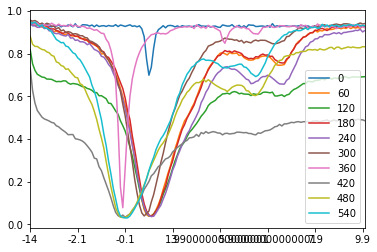

In [19]:
X.iloc[0::60,:].T.plot()

## Fitting Parameters

In [25]:
a1= .9
a2= .7
a3= .5
a4= .5

w1= 1
w2= 1
w3= 1
w4= 1

c1= 0
c2= 1
c3= 4.2
c4= 5.6

x0 = [a1,a2,a3,a4,   w1,w2,w3,w4,  c1,    c2,   c3,   c4,  1]
lb = [.1, 0,0,  0,   .1,.1,.1,.1,  c1-.1, .5,   c3-1, c4-.5,   -2]
ub = [1, .7,1,1,    3, 2, 2, 2,    c1+.1, 2.0 , c3+1, c4+.5, 2]  

d = pd.DataFrame(lb, columns=['lb'])
d['xo'] = x0
d['ub'] = ub

d.index = ['A1','A2','A3','A4','W1','W2','W3','W4','C1','C2','C3','C4','Scaling']
d

,lb,xo,ub
A1,0.1,0.9,1.0
A2,0.0,0.7,0.7
A3,0.0,0.5,1.0
A4,0.0,0.5,1.0
W1,0.1,1.0,3.0
W2,0.1,1.0,2.0
W3,0.1,1.0,2.0
W4,0.1,1.0,2.0
C1,-0.1,0.0,0.1
C2,0.5,1.0,2.0


### Test some of the fitting

Sample ID            NaN
pH                  6.75
concentration_mM      30
temperature_C         37
sat time_sec           6
sat power_uT         0.5
Name: 5, dtype: object


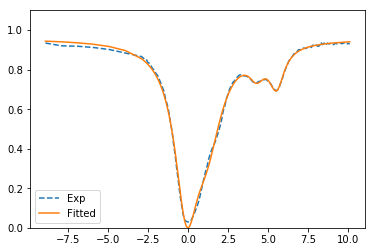

In [26]:
f = 5
s = 540


print(info.iloc[5,:])

y_data =  X.iloc[s,:].values[f::]
x_data =  center_ppm( X.columns.values[f::], y_data)

par_hat = cf.fit_lorentzian(x_data, 1-y_data, x0, lb, ub )
yhat = cf.lorentzian(x_data,par_hat)

plt.figure()
plt.plot(x_data, y_data,'--')
plt.plot(x_data, 1-yhat,'-')
plt.legend(['Exp','Fitted'])
plt.ylim([0,1.1])
plt.show()



In [27]:
%%time
info = info.assign(Peak_4p2 = 1)
info = info.assign(Peak_5p6 = 1)
peak_01 = []
peak_02 = []
for s in range(X.shape[0]):
    y_data =  X.iloc[s,:].values[f::]
    x_data =  center_ppm( X.columns.values[f::], y_data)
    par_hat = cf.fit_lorentzian(x_data, 1-y_data, x0, lb, ub )
    peak_01.append(par_hat[2])
    peak_02.append(par_hat[3])
    
    # peaks for ratiometric approach
    info.loc[s,'Peak_4p2'] = ( 1-(1-par_hat[2]) ) / (1-par_hat[2])   #par_hat[2]
    info.loc[s,'Peak_5p6'] = ( 1-(1-par_hat[3]) ) / (1-par_hat[3])   # par_hat[3]
    

CPU times: user 1min 2s, sys: 157 ms, total: 1min 2s
Wall time: 1min 2s


### Linear Model Ratios

## - Calibration Curve

In [28]:
info['RATIO'] = np.log10( info['Peak_4p2'] / info['Peak_5p6'])

f1 = info.concentration_mM == 30
f2 = info.temperature_C == 37
f3 = info['sat time_sec'] == 6
f4 = info['sat power_uT'] ==3
d = info[f1&f2&f3&f4]
d = d[d.pH <= 7.4]

In [29]:
d

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT,Peak_4p2,Peak_5p6,RATIO
45,Iopamidol,6.00,30,37,6.0,3.0,0.077342,0.142377,-0.265024
46,NaN,6.15,30,37,6.0,3.0,0.104652,0.168066,-0.205731
47,NaN,6.30,30,37,6.0,3.0,0.146265,0.176628,-0.081921
48,NaN,6.45,30,37,6.0,3.0,0.214180,0.184572,0.064614
49,NaN,6.60,30,37,6.0,3.0,0.271126,0.149910,0.257342
50,NaN,6.75,30,37,6.0,3.0,0.345238,0.116184,0.472972
51,NaN,6.90,30,37,6.0,3.0,0.485333,0.068082,0.853005
52,NaN,7.00,30,37,6.0,3.0,0.457704,0.034537,1.122297
53,NaN,7.15,30,37,6.0,3.0,0.461719,0.011342,1.609688
54,NaN,7.30,30,37,6.0,3.0,0.371852,0.003381,2.041301


/Users/Julio/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)



MSE 
 0.012448656107239197

MSE 
 0.09766768965758796


(array([316.,  33.,  14.,   8.,   7.,   3.,   1.,   2.,   4.,   2.]),
 array([1.10440015e-07, 1.21046457e-01, 2.42092804e-01, 3.63139151e-01,
        4.84185497e-01, 6.05231844e-01, 7.26278191e-01, 8.47324538e-01,
        9.68370884e-01, 1.08941723e+00, 1.21046358e+00]),
 <a list of 10 Patch objects>)

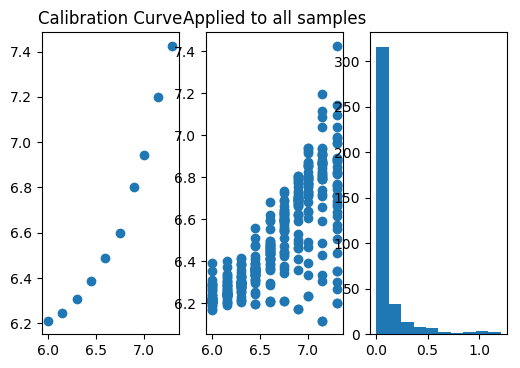

In [30]:
Xd = d['RATIO'].values.reshape(-1,1)

LR = linear_model.LinearRegression(  fit_intercept=True)
LR.fit(Xd,d.pH)
pHhat = LR.predict(Xd)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, dpi=100)

ax1.plot(d.pH, pHhat,'o')
ax1.set_title('Calibration Curve')
#ax1.ylim([5.5,7.5])

print()
print('MSE \n',metrics.regression.mean_squared_error(d.pH,LR.predict(Xd)))


## Apply Calibriton to everything

I = info[info.pH <= 7.4]

Xd = I['RATIO'].replace(np.inf,0)
Xd = Xd.values.reshape(-1,1)

yd = I.pH.copy()

pHhat1 = LR.predict(Xd)


ax2.plot(yd, pHhat1,'o')
ax2.set_title('Applied to all samples')

print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat1))

ax3.hist( (yd - pHhat1)**2)

## Train on all variables and test on all data

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    2.6s finished



MSE 
 0.0671399215043536


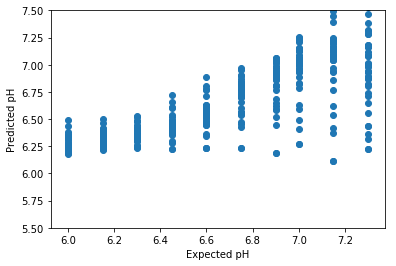

In [31]:
model_all = train_linear_regression(Xd, yd)

pHhat2 = model_all.predict(Xd)

plt.scatter(yd, pHhat2)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])

print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat2))

### Train on Spectra and test on everything

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.2s finished



MSE 
 0.035727903102311914


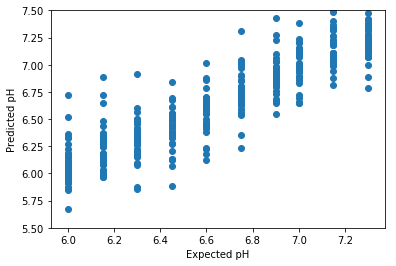

In [32]:
Xd = X[info.pH <= 7.4]
yd = info.pH[info.pH <= 7.4]

model_all = train_linear_regression(Xd, yd)

pHhat3 = model_all.predict(Xd)

plt.scatter(yd, pHhat3)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])


print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat3))

### Train on Spectra + PCA and test on everything

In [33]:
Xd.shape

(390, 142)

Fitting 3 folds for each of 492 candidates, totalling 1476 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 618 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 1476 out of 1476 | elapsed:    8.5s finished



MSE 
 0.04169372423912112


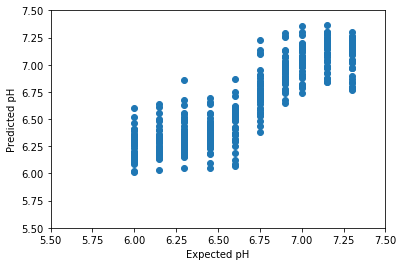

In [34]:
model_pca = train_linear_reg_pipeline(Xd, yd, max_n= 125)

pHhat4 = model_pca.predict(Xd)

plt.scatter(yd, pHhat4)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])
plt.xlim([5.5,7.5])


print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat4))

In [215]:
model_pca

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=21, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True))])

(array([312.,  47.,  14.,   9.,   6.,   1.,   0.,   0.,   0.,   1.]),
 array([5.02518887e-07, 6.52064783e-02, 1.30412454e-01, 1.95618430e-01,
        2.60824406e-01, 3.26030381e-01, 3.91236357e-01, 4.56442333e-01,
        5.21648309e-01, 5.86854284e-01, 6.52060260e-01]),
 <a list of 10 Patch objects>)

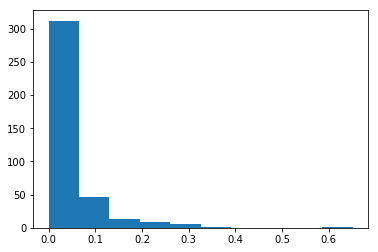

In [214]:
plt.hist( (yd - pHhat4)**2)

#### Logistic Regression

In [23]:
### define function to train model based on cuttoff for pH
def train_linear_reg_pipeline(Spectra, pH_observed, min_n=2, max_n= 10):
    # cut off > pH
    y = pH_observed
    # X data
    X = Spectra.copy()
        
    # Logistic
    linear = linear_model.LinearRegression( )
    
    #PCA
    pca = PCA(random_state=42)
    
    # pipeline
    pipe = Pipeline(steps=[('pca', pca), ('linear', linear)])
    
    # Training parameters
    num_pca_components = np.arange(min_n,max_n,1)


    param_grid ={
    'pca__n_components': num_pca_components,
    'linear__normalize': [True,False],
    'linear__fit_intercept':[True,False]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model"
    estimator.fit(X_train, y_train)

    
    return estimator.best_estimator_

In [22]:
### define function to train model based on cuttoff for pH
def train_linear_regression(Spectra, pH_observed):
    # cut off > pH
    y = pH_observed
    # X data
    X = Spectra.copy()
        
    # Logistic
    linear = linear_model.LinearRegression( )

    # Training parameters
    param_grid ={
    'normalize': [True,False],
        'fit_intercept':[False,True]
    }
    
    
    estimator = GridSearchCV(linear, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
        
    return estimator.best_estimator_

    # Grid Search on Pipeline
    estimator = GridSearchCV(logistic,
                         dict(
                              C= Cs,
                              class_weight= ['balanced',None],
                              fit_intercept= [True,False]), 
                             verbose = 1, cv = 3, n_jobs=3, iid = True)

Note on metrics
- precision = positive predictive value
- recall    = sensitivity

###  -training pH >7.0  

In [ ]:
(pH> 7).value_counts(normalize = True).round(2)

### Pipeline

In [ ]:
s = X.shape[1]
step_size = 1

In [ ]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:step_size], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 7.0, n_cs=20 )

clf_01

### Only Logistic Regression

In [ ]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_regression( X.iloc[:,0:s:step_size], pH,
                                                                           pH_cut_off = 7.0, n_cs=20 )

### pH > 6.8

In [ ]:
(pH > 6.8).value_counts(normalize = True).round(2)

In [ ]:
clf_pca, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:1], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 6.8, n_cs=20 )
clf_pca

For Mart

In [ ]:
pca = clf_pca.named_steps['pca']

In [ ]:
pca.transform(X.iloc[250:251,:])

In [ ]:
clf_pca.predict(X)

In [20]:
X

,-14.0,-13.0,-12.0,-11.0,-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,...,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
0,0.943852,0.930887,0.933898,0.932648,0.931263,0.935083,0.935146,0.938335,0.926249,0.925987,...,0.931723,0.924795,0.924161,0.930015,0.928644,0.931068,0.930976,0.926157,0.930790,0.928259
1,0.936170,0.928984,0.939271,0.934899,0.936636,0.941459,0.935309,0.941376,0.917778,0.932931,...,0.928367,0.922939,0.932863,0.933060,0.923693,0.934494,0.932646,0.930217,0.930625,0.929748
2,0.957527,0.948261,0.938385,0.951274,0.952034,0.943418,0.949914,0.937385,0.937815,0.937671,...,0.940804,0.936984,0.940136,0.936539,0.939115,0.942907,0.940608,0.942428,0.934155,0.937389
3,0.945490,0.942029,0.946585,0.947422,0.949495,0.945483,0.941511,0.936406,0.939827,0.932747,...,0.933866,0.947230,0.938395,0.933724,0.943978,0.925234,0.936695,0.937686,0.935442,0.941736
4,0.954497,0.951515,0.946875,0.949217,0.940296,0.945651,0.942306,0.943991,0.948973,0.938468,...,0.940327,0.939667,0.934850,0.943253,0.942879,0.941534,0.937508,0.939397,0.936415,0.945846
5,0.945255,0.943990,0.937298,0.939275,0.937990,0.939590,0.933397,0.936972,0.930937,0.934265,...,0.937095,0.934402,0.931527,0.931966,0.934295,0.933915,0.933035,0.932826,0.933832,0.931273
6,0.948449,0.942240,0.935157,0.940737,0.942498,0.936834,0.937700,0.931867,0.927249,0.929451,...,0.926924,0.928191,0.933831,0.930045,0.928821,0.932045,0.934518,0.930501,0.931700,0.933267
7,0.944113,0.939615,0.935927,0.938721,0.942883,0.937311,0.947894,0.944579,0.930837,0.934066,...,0.939519,0.939186,0.936825,0.928314,0.934519,0.935300,0.936168,0.935512,0.932727,0.932495
8,0.962012,0.945181,0.948440,0.946843,0.949459,0.955353,0.945728,0.939544,0.940411,0.943403,...,0.945555,0.940116,0.943269,0.941847,0.940270,0.939487,0.943783,0.942155,0.938649,0.933796
9,0.959720,0.945939,0.954158,0.948117,0.947797,0.940066,0.947917,0.945413,0.949606,0.943024,...,0.937726,0.941070,0.937405,0.943087,0.936212,0.940326,0.935565,0.942614,0.937389,0.933784


In [35]:
model_pca

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=21, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True))])

In [47]:
pca_s = model_pca.named_steps['pca']

In [56]:
np.linalg.matrix_rank( X)

142

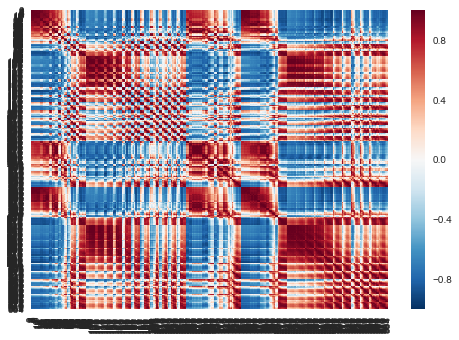

In [53]:
sns.heatmap( np.corrcoef( pca_s.transform(X) ), vmin=-1, vmax=1 )

In [52]:
sns.heatmap?

In [40]:
import seaborn as sns

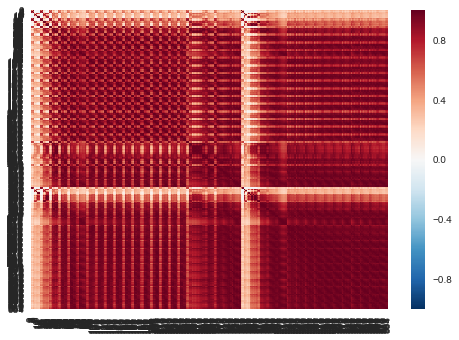

In [54]:
sns.heatmap(np.corrcoef(X) , vmin=-1, vmax=1  )